# Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from src.langsim_utils import *

# Import datasets

In [2]:
# load the WALS dataset
walsdata = pd.read_csv('../datasets/wals/language.csv', sep=',')

# load the languages dataset
nllb_lang = pd.read_csv('../EDA/nllb_languages.csv', sep=';') 

# Data cleaning

#### Select relevant languages

In [3]:
llama_lang_wals = ["bul","ctl","cze","dsh", "dut","ger","eng","fin","fre","scr","hun", "ind", "ita","jpn","kor","nor","pol","por","rus", "spa","swe","rom","slo",'tha',"vie","mnd","ukr"]

walsdata_test = walsdata.loc[walsdata['wals_code'].isin(llama_lang_wals)]

#### Extract scriptdata from NLLB and merge with WALS

In [4]:
# extract script data for each language
nllb_lang['Script'] = nllb_lang['FLORES-200 code'].str[-4:]

# change merge column name
nllb_lang.rename(columns = {'Language':'Name'}, inplace = True) 

# Change names that differ in the nllb language name and wals language name
nllb_lang.loc[nllb_lang['Name'] == 'Norwegian Nynorsk', 'Name'] = 'Norwegian'
nllb_lang.loc[nllb_lang['Name'] == 'Serbian', 'Name'] = 'Serbian-Croatian'
nllb_lang.loc[nllb_lang['Name'] == 'Slovenian', 'Name'] = 'Slovene'
nllb_lang.loc[nllb_lang['Name'] == 'Chinese (Traditional)', 'Name'] = 'Mandarin'

# merge the script values to the WALS dataset based on the language name
walsdata_test = pd.merge(walsdata_test, nllb_lang)

# rename walsdata language names for simplicity
walsdata_test.loc[walsdata_test['Name'] == 'Mandarin', 'Name'] = 'Chinese'

walsdata_test.shape


(27, 204)

#### Remove languages with <25 features filled and remove features with <10% coverage

In [5]:
mask = walsdata_test.isnull().sum(axis=1) >= 25

removed1 = len(walsdata_test) - len(mask)

walsdata_test = walsdata_test[mask]

print('Removed languages (<25 features):',removed1)

Removed languages (<25 features): 0


In [6]:
missing_values = walsdata_test.isnull().sum(axis=0)

threshold = len(walsdata_test) - np.ceil(len(walsdata_test)/10)

features_above_threshold = missing_values[missing_values >= threshold].index.tolist()

walsdata_test = walsdata_test.drop(columns=features_above_threshold)

removed2 = len(features_above_threshold)

print('Removed features (<10% coverage):',removed2)

Removed features (<10% coverage): 26


In [7]:
walsdata_test

,wals_code,iso_code,glottocode,Name,latitude,longitude,genus,family,macroarea,countrycodes,...,137B M in Second Person Singular,136B M in First Person Singular,109B Other Roles of Applied Objects,25B Zero Marking of A and P Arguments,21B Exponence of Tense-Aspect-Mood Inflection,108B Productivity of the Antipassive Construction,58B Number of Possessive Nouns,79B Suppletion in Imperatives and Hortatives,FLORES-200 code,Script
0,bul,bul,bulg1262,Bulgarian,42.50,25.0,Slavic,Indo-European,Eurasia,BG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 A regular and a suppletive form alternate,bul_Cyrl,Cyrl
1,ctl,cat,stan1289,Catalan,41.75,2.0,Romance,Indo-European,Eurasia,ES,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cat_Latn,Latn
2,cze,ces,czec1258,Czech,50.00,15.0,Slavic,Indo-European,Eurasia,CZ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 None (= no suppletive imperatives reported i...,ces_Latn,Latn
3,dsh,dan,dani1285,Danish,56.00,10.0,Germanic,Indo-European,Eurasia,DK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dan_Latn,Latn
4,dut,nld,dutc1256,Dutch,52.50,6.0,Germanic,Indo-European,Eurasia,NL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 None (= no suppletive imperatives reported i...,nld_Latn,Latn
5,eng,eng,stan1293,English,52.00,0.0,Germanic,Indo-European,Eurasia,GB IE,...,1 No m in second person singular,2 m in first person singular,5 No applicative construction,2 Non-zero marking,1 monoexponential TAM,4 no antipassive,1 None reported,5 None (= no suppletive imperatives reported i...,eng_Latn,Latn
6,fin,fin,finn1318,Finnish,62.00,25.0,Finnic,Uralic,Eurasia,FI,...,1 No m in second person singular,2 m in first person singular,5 No applicative construction,2 Non-zero marking,1 monoexponential TAM,4 no antipassive,1 None reported,2 Imperative,fin_Latn,Latn
7,fre,fra,stan1290,French,48.00,2.0,Romance,Indo-European,Eurasia,CH FR,...,1 No m in second person singular,2 m in first person singular,5 No applicative construction,2 Non-zero marking,2 TAM+agreement,4 no antipassive,1 None reported,5 None (= no suppletive imperatives reported i...,fra_Latn,Latn
8,ger,deu,stan1295,German,52.00,10.0,Germanic,Indo-European,Eurasia,AT DE CH,...,1 No m in second person singular,2 m in first person singular,5 No applicative construction,2 Non-zero marking,1 monoexponential TAM,4 no antipassive,1 None reported,5 None (= no suppletive imperatives reported i...,deu_Latn,Latn
9,hun,hun,hung1274,Hungarian,47.00,20.0,Ugric,Uralic,Eurasia,HU,...,1 No m in second person singular,2 m in first person singular,5 No applicative construction,2 Non-zero marking,1 monoexponential TAM,4 no antipassive,1 None reported,1 A regular and a suppletive form alternate,hun_Latn,Latn


#### Select relevant features

In [8]:
### feature groups
genus = ['genus']
family = ['family']
script = ['Script']
phonology = ['1A Consonant Inventories','2A Vowel Quality Inventories','3A Consonant-Vowel Ratio','4A Voicing in Plosives and Fricatives','5A Voicing and Gaps in Plosive Systems','6A Uvular Consonants','7A Glottalized Consonants','8A Lateral Consonants','9A The Velar Nasal','10A Vowel Nasalization','11A Front Rounded Vowels','12A Syllable Structure','13A Tone','14A Fixed Stress Locations','15A Weight-Sensitive Stress','16A Weight Factors in Weight-Sensitive Stress Systems','17A Rhythm Types','18A Absence of Common Consonants','19A Presence of Uncommon Consonants']
morphology = ['20A Fusion of Selected Inflectional Formatives','21A Exponence of Selected Inflectional Formatives','22A Inflectional Synthesis of the Verb','23A Locus of Marking in the Clause','24A Locus of Marking in Possessive Noun Phrases','25A Locus of Marking: Whole-language Typology','26A Prefixing vs. Suffixing in Inflectional Morphology','27A Reduplication','28A Case Syncretism','29A Syncretism in Verbal Person/Number Marking']
nominal_cat = ['30A Number of Genders','31A Sex-based and Non-sex-based Gender Systems','32A Systems of Gender Assignment','33A Coding of Nominal Plurality','34A Occurrence of Nominal Plurality','35A Plurality in Independent Personal Pronouns','36A The Associative Plural','37A Definite Articles','38A Indefinite Articles','39A Inclusive/Exclusive Distinction in Independent Pronouns','40A Inclusive/Exclusive Distinction in Verbal Inflection','41A Distance Contrasts in Demonstratives','42A Pronominal and Adnominal Demonstratives','43A Third Person Pronouns and Demonstratives','44A Gender Distinctions in Independent Personal Pronouns','45A Politeness Distinctions in Pronouns','46A Indefinite Pronouns','47A Intensifiers and Reflexive Pronouns','48A Person Marking on Adpositions','49A Number of Cases','50A Asymmetrical Case-Marking','51A Position of Case Affixes','52A Comitatives and Instrumentals','53A Ordinal Numerals','54A Distributive Numerals','55A Numeral Classifiers','56A Conjunctions and Universal Quantifiers','57A Position of Pronominal Possessive Affixes']
nominal_syn = ['58A Obligatory Possessive Inflection','59A Possessive Classification','60A Genitives, Adjectives and Relative Clauses','61A Adjectives without Nouns','62A Action Nominal Constructions','63A Noun Phrase Conjunction','64A Nominal and Verbal Conjunction']
verbal_cat = ['65A Perfective/Imperfective Aspect','66A The Past Tense','67A The Future Tense','68A The Perfect','69A Position of Tense-Aspect Affixes','70A The Morphological Imperative','71A The Prohibitive','72A Imperative-Hortative Systems','73A The Optative','74A Situational Possibility','75A Epistemic Possibility','76A Overlap between Situational and Epistemic Modal Marking','77A Semantic Distinctions of Evidentiality','78A Coding of Evidentiality','79A Suppletion According to Tense and Aspect','80A Verbal Number and Suppletion']
wordorder = ['81A Order of Subject, Object and Verb','82A Order of Subject and Verb','83A Order of Object and Verb','84A Order of Object, Oblique, and Verb','85A Order of Adposition and Noun Phrase','86A Order of Genitive and Noun','87A Order of Adjective and Noun','88A Order of Demonstrative and Noun','89A Order of Numeral and Noun','90A Order of Relative Clause and Noun','91A Order of Degree Word and Adjective','92A Position of Polar Question Particles','93A Position of Interrogative Phrases in Content Questions','94A Order of Adverbial Subordinator and Clause','95A Relationship between the Order of Object and Verb and the Order of Adposition and Noun Phrase','96A Relationship between the Order of Object and Verb and the Order of Relative Clause and Noun','97A Relationship between the Order of Object and Verb and the Order of Adjective and Noun','143A Order of Negative Morpheme and Verb','143B Obligatory Double Negation','143C Optional Double Negation','143D Optional Triple Negation','143E Preverbal Negative Morphemes','143F Postverbal Negative Morphemes','143G Minor morphological means of signaling negation','144A Position of Negative Word With Respect to Subject, Object, and Verb','144B Position of negative words relative to beginning and end of clause and with respect to adjacency to verb','144C Languages with different word order in negative clauses','144D The Position of Negative Morphemes in SVO Languages','144E Multiple Negative Constructions in SVO Languages','144F Obligatory Double Negation in SVO languages','144G Optional Double Negation in SVO languages','144H NegSVO Order','144I SNegVO Order','144J SVNegO Order','144K SVONeg Order','144L The Position of Negative Morphemes in SOV Languages','144M Multiple Negative Constructions in SOV Languages','144N Obligatory Double Negation in SOV languages','144O Optional Double Negation in SOV languages','144P NegSOV Order','144Q SNegOV Order','144R SONegV Order','144S SOVNeg Order','144T The Position of Negative Morphemes in Verb-Initial Languages','144U Double negation in verb-initial languages','144V Verb-Initial with Preverbal Negative','144W Verb-Initial with Negative that is Immediately Postverbal or between Subject and Object','144X Verb-Initial with Clause-Final Negative','144Y The Position of Negative Morphemes in Object-Initial Languages']
simple_clause = ["100A Alignment of Verbal Person Marking","101A Expression of Pronominal Subjects","102A Verbal Person Marking","103A Third Person Zero of Verbal Person Marking","104A Order of Person Markers on the Verb","105A Ditransitive Constructions: The Verb 'Give'","106A Reciprocal Constructions","107A Passive Constructions","108A Antipassive Constructions","108B Productivity of the Antipassive Construction","109A Applicative Constructions","109B Other Roles of Applied Objects","110A Periphrastic Causative Constructions","111A Nonperiphrastic Causative Constructions","112A Negative Morphemes","113A Symmetric and Asymmetric Standard Negation","114A Subtypes of Asymmetric Standard Negation","115A Negative Indefinite Pronouns and Predicate Negation","116A Polar Questions","117A Predicative Possession","118A Predicative Adjectives","119A Nominal and Locational Predication","120A Zero Copula for Predicate Nominals","121A Comparative Constructions"]
complex_sentences = ["122A Relativization on Subjects","123A Relativization on Obliques","124A 'Want' Complement Subjects","125A Purpose Clauses","126A 'When' Clauses","127A Reason Clauses","128A Utterance Complement Clauses"]
lexicon = ['129A Hand and Arm','130A Finger and Hand','131A Numeral Bases','132A Number of Non-Derived Basic Colour Categories','133A Number of Basic Colour Categories','134A Green and Blue','135A Red and Yellow','136A M-T Pronouns','137A N-M Pronouns','138A Tea']

A similarity measure that is designed to handle empty cells is used. Given two languages $A$ and $B$, the $\textrm{shared overlap}(A, B)$ is defined to as

\begin{equation*}
    \textrm{Shared overlap}(A, B) = \frac{\textrm{\# Features with same values}}{\textrm{\# Features both filled out in WALS}}. 
\end{equation*} \\

This measure can handle language pairs with many empty cells in WALS as it uses only features with cells filled out for both languages, and calculates the percentage of features with the same values.

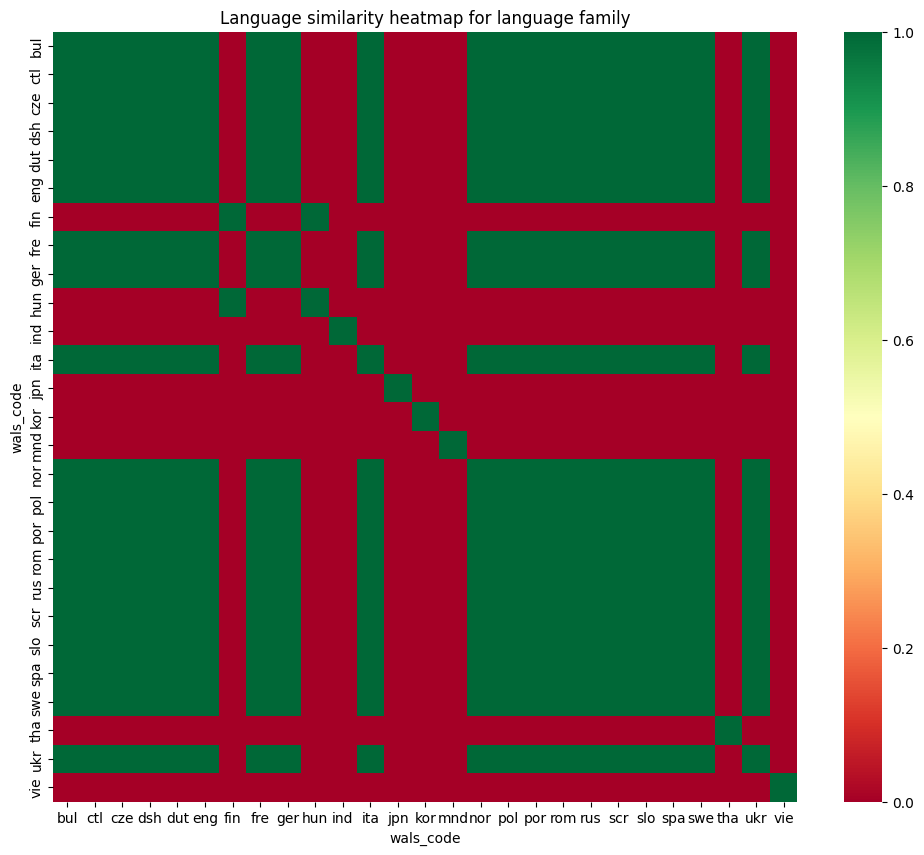

In [15]:
plt.figure(figsize=(12, 10))
sns.heatmap(get_sim_df(walsdata_test,walsdata_test['wals_code'],family), annot=False, cmap='RdYlGn', fmt=".2f")
plt.title('Language similarity heatmap for language family')
plt.show()